In [1]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import imageio
from tqdm import tqdm
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_shape, output_dim):
        super(ActorCriticNetwork, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
        )
        
        self.policy_head = nn.Linear(512, output_dim)
        self.value_head = nn.Linear(512, 1)

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.conv(x).view(x.size()[0], -1)  # Преобразование в одномерный вектор
        x = self.fc(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

In [3]:
class PPOAgent:
    def __init__(self, env, gamma, lr, epsilon, batch_size):
        self.env = env
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.batch_size = batch_size

        self.state_shape = (4, 84, 84)
        self.num_actions = env.action_space.n

        # Модель сети
        self.network = ActorCriticNetwork(self.state_shape, self.num_actions).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)

        self.states = []
        self.actions = []
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []
        self.returns = []  # Для хранения вознаграждений после обновления
        self.advantages = []  # Для хранения преимуществ

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        policy, value = self.network(state)

        dist = Categorical(logits=policy)
        action = dist.sample()

        self.log_probs.append(dist.log_prob(action))
        self.values.append(value)

        self.states.append(state)  
        self.actions.append(action)

        return action.item()

    def store_transition(self, reward, done):
        self.rewards.append(reward)
        self.dones.append(done)

    def compute_advantages(self, next_value):
        advantages = []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            delta = self.rewards[t] + self.gamma * (self.dones[t] * next_value - self.values[t]) - self.values[t]
            gae = delta + self.gamma * gae
            advantages.insert(0, gae)
            next_value = self.values[t]
        return advantages

    def compute_returns(self):
        returns = []
        return_ = 0
        for reward, done in zip(reversed(self.rewards), reversed(self.dones)):
            return_ = reward + self.gamma * return_ * (1 - done)
            returns.insert(0, return_)
        return returns

    def update(self, states, actions, log_probs, values, rewards, dones):
        if len(rewards) == 0:
            raise ValueError("Rewards list is empty, unable to compute returns or advantages.")

        states = torch.cat([torch.tensor(state, dtype=torch.float32) for state in states]).to(device)
        actions = torch.tensor(actions).to(device)
        old_log_probs = torch.stack(log_probs).detach()

        returns = self.compute_returns()  
        
        if len(returns) == 0:
            raise ValueError("Returns list is empty, unable to compute advantages.")

        # Вычисляем преимущества
        advantages = self.compute_advantages(returns[-1])

        # Конвертируем returns и advantages в тензоры
        returns = torch.tensor(returns).to(device)
        advantages = torch.tensor(advantages).to(device)

        # Получаем прогнозы и ценности из сети
        policy, value = self.network(states)
        dist = Categorical(logits=policy)
        log_probs = dist.log_prob(actions)

        # Вычисление соотношения и потерь
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages

        policy_loss = -torch.min(surr1, surr2).mean()
        value_loss = (returns - value).pow(2).mean()

        loss = policy_loss + 0.5 * value_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []
        self.states = []  # Очищаем состояния
        self.actions = []  # Очищаем действия

In [4]:
def show_frame(frame):
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [5]:
def train(env, device, episodes, batch_size, gamma, epsilon, lr):
    agent = PPOAgent(env, gamma, lr, epsilon, batch_size)

    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        state_gray = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        state_resized = cv2.resize(state_gray, (84, 84))
        state_stack = np.stack([state_resized] * 4, axis=0)

        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state_stack)
            next_state, reward, done, truncated, _ = env.step(action)

            next_state_gray = cv2.cvtColor(next_state, cv2.COLOR_RGB2GRAY)
            next_state_resized = cv2.resize(next_state_gray, (84, 84))
            next_state_stack = np.append(state_stack[1:], np.expand_dims(next_state_resized, axis=0), axis=0)

            agent.store_transition(reward, done)

            state_stack = next_state_stack
            episode_reward += reward

        agent.update(agent.states, agent.actions, agent.log_probs, agent.values, agent.rewards, agent.dones)

        if episode % 100 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")
            show_frame(next_state)
            
        print(f"End of Episode {episode}: Total Reward: {episode_reward}")

    torch.save(agent.network.state_dict(), "breakout_ppo_model1.pth")
    print("Model saved as breakout_ppo_model.pth")

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_3308\723820632.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(state, dtype=torch.float32) for state in states]).to(device)


Episode 0, Reward: 0.0


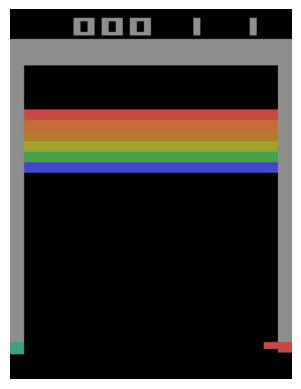

  0%|          | 1/500 [00:00<06:50,  1.21it/s]

End of Episode 0: Total Reward: 0.0


  0%|          | 2/500 [00:02<10:31,  1.27s/it]

End of Episode 1: Total Reward: 3.0


  1%|          | 3/500 [00:07<23:31,  2.84s/it]

End of Episode 2: Total Reward: 3.0


  1%|          | 4/500 [00:13<36:04,  4.36s/it]

End of Episode 3: Total Reward: 3.0


  1%|          | 5/500 [00:18<36:03,  4.37s/it]

End of Episode 4: Total Reward: 11.0


  1%|          | 6/500 [00:21<32:33,  3.96s/it]

End of Episode 5: Total Reward: 7.0


  1%|▏         | 7/500 [00:23<26:41,  3.25s/it]

End of Episode 6: Total Reward: 7.0


  2%|▏         | 8/500 [00:24<21:10,  2.58s/it]

End of Episode 7: Total Reward: 7.0


  2%|▏         | 9/500 [00:24<16:12,  1.98s/it]

End of Episode 8: Total Reward: 2.0


  2%|▏         | 10/500 [00:25<12:31,  1.53s/it]

End of Episode 9: Total Reward: 1.0


  2%|▏         | 11/500 [00:25<09:56,  1.22s/it]

End of Episode 10: Total Reward: 1.0


  2%|▏         | 12/500 [00:26<08:08,  1.00s/it]

End of Episode 11: Total Reward: 1.0


  3%|▎         | 13/500 [00:27<07:26,  1.09it/s]

End of Episode 12: Total Reward: 3.0


  3%|▎         | 14/500 [00:27<06:24,  1.26it/s]

End of Episode 13: Total Reward: 1.0


  3%|▎         | 15/500 [00:28<05:45,  1.41it/s]

End of Episode 14: Total Reward: 1.0


  3%|▎         | 16/500 [00:28<05:36,  1.44it/s]

End of Episode 15: Total Reward: 2.0


  3%|▎         | 17/500 [00:29<06:14,  1.29it/s]

End of Episode 16: Total Reward: 7.0


  4%|▎         | 18/500 [00:30<06:13,  1.29it/s]

End of Episode 17: Total Reward: 3.0


  4%|▍         | 19/500 [00:31<06:28,  1.24it/s]

End of Episode 18: Total Reward: 7.0


  4%|▍         | 20/500 [00:32<06:24,  1.25it/s]

End of Episode 19: Total Reward: 3.0


  4%|▍         | 21/500 [00:33<06:12,  1.29it/s]

End of Episode 20: Total Reward: 3.0


  4%|▍         | 22/500 [00:33<06:17,  1.27it/s]

End of Episode 21: Total Reward: 7.0


  5%|▍         | 23/500 [00:34<05:58,  1.33it/s]

End of Episode 22: Total Reward: 2.0


  5%|▍         | 24/500 [00:35<06:00,  1.32it/s]

End of Episode 23: Total Reward: 3.0


  5%|▌         | 25/500 [00:35<05:31,  1.43it/s]

End of Episode 24: Total Reward: 1.0


  5%|▌         | 26/500 [00:36<05:35,  1.41it/s]

End of Episode 25: Total Reward: 3.0


  5%|▌         | 27/500 [00:37<05:36,  1.41it/s]

End of Episode 26: Total Reward: 3.0


  6%|▌         | 28/500 [00:38<05:43,  1.37it/s]

End of Episode 27: Total Reward: 3.0


  6%|▌         | 29/500 [00:38<06:12,  1.26it/s]

End of Episode 28: Total Reward: 11.0


  6%|▌         | 30/500 [00:39<05:50,  1.34it/s]

End of Episode 29: Total Reward: 2.0


  6%|▌         | 31/500 [00:40<05:44,  1.36it/s]

End of Episode 30: Total Reward: 2.0


  6%|▋         | 32/500 [00:41<05:49,  1.34it/s]

End of Episode 31: Total Reward: 3.0


  7%|▋         | 33/500 [00:41<05:47,  1.34it/s]

End of Episode 32: Total Reward: 3.0


  7%|▋         | 34/500 [00:42<05:45,  1.35it/s]

End of Episode 33: Total Reward: 2.0


  7%|▋         | 35/500 [00:43<05:16,  1.47it/s]

End of Episode 34: Total Reward: 1.0


  7%|▋         | 36/500 [00:43<05:13,  1.48it/s]

End of Episode 35: Total Reward: 2.0


  7%|▋         | 37/500 [00:44<05:21,  1.44it/s]

End of Episode 36: Total Reward: 2.0


  8%|▊         | 38/500 [00:45<05:36,  1.37it/s]

End of Episode 37: Total Reward: 2.0


  8%|▊         | 39/500 [00:46<05:39,  1.36it/s]

End of Episode 38: Total Reward: 2.0


  8%|▊         | 40/500 [00:46<05:05,  1.51it/s]

End of Episode 39: Total Reward: 0.0


  8%|▊         | 41/500 [00:47<05:14,  1.46it/s]

End of Episode 40: Total Reward: 2.0


  8%|▊         | 42/500 [00:47<04:40,  1.63it/s]

End of Episode 41: Total Reward: 0.0


  9%|▊         | 43/500 [00:48<04:20,  1.75it/s]

End of Episode 42: Total Reward: 0.0


  9%|▉         | 44/500 [00:49<04:51,  1.56it/s]

End of Episode 43: Total Reward: 3.0


  9%|▉         | 45/500 [00:49<04:36,  1.64it/s]

End of Episode 44: Total Reward: 1.0


  9%|▉         | 46/500 [00:50<04:40,  1.62it/s]

End of Episode 45: Total Reward: 2.0


  9%|▉         | 47/500 [00:51<05:40,  1.33it/s]

End of Episode 46: Total Reward: 5.0


 10%|▉         | 48/500 [00:51<05:28,  1.37it/s]

End of Episode 47: Total Reward: 1.0


 10%|▉         | 49/500 [00:52<05:19,  1.41it/s]

End of Episode 48: Total Reward: 1.0


 10%|█         | 50/500 [00:53<05:21,  1.40it/s]

End of Episode 49: Total Reward: 2.0


 10%|█         | 51/500 [00:54<05:13,  1.43it/s]

End of Episode 50: Total Reward: 1.0


 10%|█         | 52/500 [00:54<04:43,  1.58it/s]

End of Episode 51: Total Reward: 0.0


 11%|█         | 53/500 [00:55<05:08,  1.45it/s]

End of Episode 52: Total Reward: 2.0


 11%|█         | 54/500 [00:56<05:24,  1.37it/s]

End of Episode 53: Total Reward: 2.0


 11%|█         | 55/500 [00:57<05:48,  1.28it/s]

End of Episode 54: Total Reward: 3.0


 11%|█         | 56/500 [00:57<05:19,  1.39it/s]

End of Episode 55: Total Reward: 1.0


 11%|█▏        | 57/500 [00:58<04:51,  1.52it/s]

End of Episode 56: Total Reward: 0.0


 12%|█▏        | 58/500 [00:58<04:50,  1.52it/s]

End of Episode 57: Total Reward: 1.0


 12%|█▏        | 59/500 [00:59<04:29,  1.64it/s]

End of Episode 58: Total Reward: 0.0


 12%|█▏        | 60/500 [00:59<04:16,  1.72it/s]

End of Episode 59: Total Reward: 0.0


 12%|█▏        | 61/500 [01:00<04:25,  1.65it/s]

End of Episode 60: Total Reward: 1.0


 12%|█▏        | 62/500 [01:01<04:37,  1.58it/s]

End of Episode 61: Total Reward: 1.0


 13%|█▎        | 63/500 [01:02<05:07,  1.42it/s]

End of Episode 62: Total Reward: 3.0


 13%|█▎        | 64/500 [01:02<05:16,  1.38it/s]

End of Episode 63: Total Reward: 2.0


 13%|█▎        | 65/500 [01:03<04:44,  1.53it/s]

End of Episode 64: Total Reward: 0.0


 13%|█▎        | 66/500 [01:04<04:54,  1.47it/s]

End of Episode 65: Total Reward: 2.0


 13%|█▎        | 67/500 [01:04<04:50,  1.49it/s]

End of Episode 66: Total Reward: 1.0


 14%|█▎        | 68/500 [01:05<05:21,  1.34it/s]

End of Episode 67: Total Reward: 3.0


 14%|█▍        | 69/500 [01:06<06:12,  1.16it/s]

End of Episode 68: Total Reward: 4.0


 14%|█▍        | 70/500 [01:07<06:35,  1.09it/s]

End of Episode 69: Total Reward: 3.0


 14%|█▍        | 71/500 [01:08<05:56,  1.20it/s]

End of Episode 70: Total Reward: 0.0


 14%|█▍        | 72/500 [01:09<06:10,  1.16it/s]

End of Episode 71: Total Reward: 3.0


 15%|█▍        | 73/500 [01:09<05:38,  1.26it/s]

End of Episode 72: Total Reward: 0.0


 15%|█▍        | 74/500 [01:10<05:26,  1.31it/s]

End of Episode 73: Total Reward: 1.0


 15%|█▌        | 75/500 [01:11<05:29,  1.29it/s]

End of Episode 74: Total Reward: 2.0


 15%|█▌        | 76/500 [01:12<04:57,  1.42it/s]

End of Episode 75: Total Reward: 0.0


 15%|█▌        | 77/500 [01:12<05:18,  1.33it/s]

End of Episode 76: Total Reward: 2.0


 16%|█▌        | 78/500 [01:13<05:51,  1.20it/s]

End of Episode 77: Total Reward: 2.0


 16%|█▌        | 79/500 [01:14<05:34,  1.26it/s]

End of Episode 78: Total Reward: 1.0


 16%|█▌        | 80/500 [01:15<05:07,  1.37it/s]

End of Episode 79: Total Reward: 0.0


 16%|█▌        | 81/500 [01:15<05:02,  1.38it/s]

End of Episode 80: Total Reward: 1.0


 16%|█▋        | 82/500 [01:16<05:11,  1.34it/s]

End of Episode 81: Total Reward: 2.0


 17%|█▋        | 83/500 [01:17<05:52,  1.18it/s]

End of Episode 82: Total Reward: 4.0


 17%|█▋        | 84/500 [01:18<05:31,  1.26it/s]

End of Episode 83: Total Reward: 1.0


 17%|█▋        | 85/500 [01:18<04:58,  1.39it/s]

End of Episode 84: Total Reward: 0.0


 17%|█▋        | 86/500 [01:19<05:13,  1.32it/s]

End of Episode 85: Total Reward: 2.0


 17%|█▋        | 87/500 [01:20<06:02,  1.14it/s]

End of Episode 86: Total Reward: 4.0


 18%|█▊        | 88/500 [01:21<05:34,  1.23it/s]

End of Episode 87: Total Reward: 1.0


 18%|█▊        | 89/500 [01:22<05:35,  1.23it/s]

End of Episode 88: Total Reward: 2.0


 18%|█▊        | 90/500 [01:23<05:33,  1.23it/s]

End of Episode 89: Total Reward: 2.0


 18%|█▊        | 91/500 [01:24<05:29,  1.24it/s]

End of Episode 90: Total Reward: 2.0


 18%|█▊        | 92/500 [01:24<04:59,  1.36it/s]

End of Episode 91: Total Reward: 0.0


 19%|█▊        | 93/500 [01:25<04:26,  1.52it/s]

End of Episode 92: Total Reward: 0.0


 19%|█▉        | 94/500 [01:25<04:19,  1.56it/s]

End of Episode 93: Total Reward: 1.0


 19%|█▉        | 95/500 [01:26<04:09,  1.62it/s]

End of Episode 94: Total Reward: 0.0


 19%|█▉        | 96/500 [01:27<04:25,  1.52it/s]

End of Episode 95: Total Reward: 2.0


 19%|█▉        | 97/500 [01:27<04:23,  1.53it/s]

End of Episode 96: Total Reward: 1.0


 20%|█▉        | 98/500 [01:28<04:25,  1.51it/s]

End of Episode 97: Total Reward: 1.0


 20%|█▉        | 99/500 [01:28<04:08,  1.61it/s]

End of Episode 98: Total Reward: 0.0


 20%|██        | 100/500 [01:29<04:16,  1.56it/s]

End of Episode 99: Total Reward: 1.0
Episode 100, Reward: 0.0


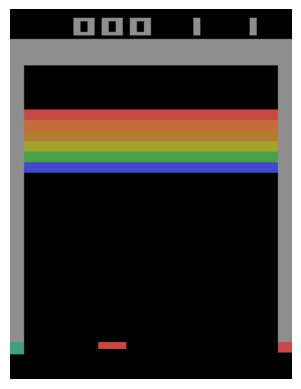

 20%|██        | 101/500 [01:30<04:05,  1.63it/s]

End of Episode 100: Total Reward: 0.0


 20%|██        | 102/500 [01:30<04:00,  1.66it/s]

End of Episode 101: Total Reward: 0.0


 21%|██        | 103/500 [01:31<04:09,  1.59it/s]

End of Episode 102: Total Reward: 1.0


 21%|██        | 104/500 [01:32<04:29,  1.47it/s]

End of Episode 103: Total Reward: 2.0


 21%|██        | 105/500 [01:32<04:23,  1.50it/s]

End of Episode 104: Total Reward: 0.0


 21%|██        | 106/500 [01:33<04:16,  1.53it/s]

End of Episode 105: Total Reward: 1.0


 21%|██▏       | 107/500 [01:34<04:44,  1.38it/s]

End of Episode 106: Total Reward: 2.0


 22%|██▏       | 108/500 [01:35<04:59,  1.31it/s]

End of Episode 107: Total Reward: 2.0


 22%|██▏       | 109/500 [01:35<04:31,  1.44it/s]

End of Episode 108: Total Reward: 0.0


 22%|██▏       | 110/500 [01:36<04:03,  1.60it/s]

End of Episode 109: Total Reward: 0.0


 22%|██▏       | 111/500 [01:36<04:02,  1.61it/s]

End of Episode 110: Total Reward: 1.0


 22%|██▏       | 112/500 [01:37<03:43,  1.74it/s]

End of Episode 111: Total Reward: 0.0


 23%|██▎       | 113/500 [01:37<03:54,  1.65it/s]

End of Episode 112: Total Reward: 1.0


 23%|██▎       | 114/500 [01:38<04:43,  1.36it/s]

End of Episode 113: Total Reward: 3.0


 23%|██▎       | 115/500 [01:39<04:27,  1.44it/s]

End of Episode 114: Total Reward: 0.0


 23%|██▎       | 116/500 [01:40<04:29,  1.42it/s]

End of Episode 115: Total Reward: 1.0


 23%|██▎       | 117/500 [01:41<04:38,  1.37it/s]

End of Episode 116: Total Reward: 2.0


 24%|██▎       | 118/500 [01:41<04:06,  1.55it/s]

End of Episode 117: Total Reward: 0.0


 24%|██▍       | 119/500 [01:42<04:27,  1.43it/s]

End of Episode 118: Total Reward: 3.0


 24%|██▍       | 120/500 [01:42<04:04,  1.56it/s]

End of Episode 119: Total Reward: 0.0


 24%|██▍       | 121/500 [01:43<04:14,  1.49it/s]

End of Episode 120: Total Reward: 2.0


 24%|██▍       | 122/500 [01:44<03:50,  1.64it/s]

End of Episode 121: Total Reward: 0.0


 25%|██▍       | 123/500 [01:44<04:12,  1.50it/s]

End of Episode 122: Total Reward: 2.0


 25%|██▍       | 124/500 [01:45<04:20,  1.44it/s]

End of Episode 123: Total Reward: 2.0


 25%|██▌       | 125/500 [01:46<04:09,  1.50it/s]

End of Episode 124: Total Reward: 1.0


 25%|██▌       | 126/500 [01:46<03:49,  1.63it/s]

End of Episode 125: Total Reward: 0.0


 25%|██▌       | 127/500 [01:47<03:39,  1.70it/s]

End of Episode 126: Total Reward: 0.0


 26%|██▌       | 128/500 [01:47<03:26,  1.80it/s]

End of Episode 127: Total Reward: 0.0


 26%|██▌       | 129/500 [01:48<03:57,  1.56it/s]

End of Episode 128: Total Reward: 2.0


 26%|██▌       | 130/500 [01:49<04:06,  1.50it/s]

End of Episode 129: Total Reward: 2.0


 26%|██▌       | 131/500 [01:50<04:10,  1.47it/s]

End of Episode 130: Total Reward: 1.0


 26%|██▋       | 132/500 [01:50<04:10,  1.47it/s]

End of Episode 131: Total Reward: 1.0


 27%|██▋       | 133/500 [01:51<04:36,  1.33it/s]

End of Episode 132: Total Reward: 3.0


 27%|██▋       | 134/500 [01:52<04:29,  1.36it/s]

End of Episode 133: Total Reward: 1.0


 27%|██▋       | 135/500 [01:53<04:26,  1.37it/s]

End of Episode 134: Total Reward: 1.0


 27%|██▋       | 136/500 [01:53<04:18,  1.41it/s]

End of Episode 135: Total Reward: 1.0


 27%|██▋       | 137/500 [01:54<04:12,  1.44it/s]

End of Episode 136: Total Reward: 1.0


 28%|██▊       | 138/500 [01:54<03:50,  1.57it/s]

End of Episode 137: Total Reward: 0.0


 28%|██▊       | 139/500 [01:55<04:40,  1.29it/s]

End of Episode 138: Total Reward: 5.0


 28%|██▊       | 140/500 [01:56<04:51,  1.24it/s]

End of Episode 139: Total Reward: 2.0


 28%|██▊       | 141/500 [01:57<04:41,  1.27it/s]

End of Episode 140: Total Reward: 1.0


 28%|██▊       | 142/500 [01:58<04:16,  1.40it/s]

End of Episode 141: Total Reward: 0.0


 29%|██▊       | 143/500 [01:58<04:10,  1.42it/s]

End of Episode 142: Total Reward: 1.0


 29%|██▉       | 144/500 [01:59<03:45,  1.58it/s]

End of Episode 143: Total Reward: 0.0


 29%|██▉       | 145/500 [01:59<03:35,  1.65it/s]

End of Episode 144: Total Reward: 0.0


 29%|██▉       | 146/500 [02:00<03:32,  1.67it/s]

End of Episode 145: Total Reward: 1.0


 29%|██▉       | 147/500 [02:01<03:56,  1.49it/s]

End of Episode 146: Total Reward: 2.0


 30%|██▉       | 148/500 [02:02<04:18,  1.36it/s]

End of Episode 147: Total Reward: 3.0


 30%|██▉       | 149/500 [02:02<04:11,  1.39it/s]

End of Episode 148: Total Reward: 1.0


 30%|███       | 150/500 [02:03<04:20,  1.34it/s]

End of Episode 149: Total Reward: 2.0


 30%|███       | 151/500 [02:04<04:07,  1.41it/s]

End of Episode 150: Total Reward: 1.0


 30%|███       | 152/500 [02:04<03:54,  1.49it/s]

End of Episode 151: Total Reward: 1.0


 31%|███       | 153/500 [02:05<03:44,  1.55it/s]

End of Episode 152: Total Reward: 0.0


 31%|███       | 154/500 [02:06<03:57,  1.45it/s]

End of Episode 153: Total Reward: 2.0


 31%|███       | 155/500 [02:06<03:52,  1.48it/s]

End of Episode 154: Total Reward: 1.0


 31%|███       | 156/500 [02:07<04:21,  1.32it/s]

End of Episode 155: Total Reward: 3.0


 31%|███▏      | 157/500 [02:08<04:02,  1.42it/s]

End of Episode 156: Total Reward: 1.0


 32%|███▏      | 158/500 [02:08<03:39,  1.56it/s]

End of Episode 157: Total Reward: 0.0


 32%|███▏      | 159/500 [02:09<03:36,  1.57it/s]

End of Episode 158: Total Reward: 1.0


 32%|███▏      | 160/500 [02:10<03:31,  1.61it/s]

End of Episode 159: Total Reward: 0.0


 32%|███▏      | 161/500 [02:10<03:17,  1.72it/s]

End of Episode 160: Total Reward: 0.0


 32%|███▏      | 162/500 [02:11<03:13,  1.74it/s]

End of Episode 161: Total Reward: 1.0


 33%|███▎      | 163/500 [02:12<03:55,  1.43it/s]

End of Episode 162: Total Reward: 3.0


 33%|███▎      | 164/500 [02:12<03:32,  1.58it/s]

End of Episode 163: Total Reward: 0.0


 33%|███▎      | 165/500 [02:13<03:45,  1.49it/s]

End of Episode 164: Total Reward: 2.0


 33%|███▎      | 166/500 [02:14<03:57,  1.41it/s]

End of Episode 165: Total Reward: 2.0


 33%|███▎      | 167/500 [02:14<03:37,  1.53it/s]

End of Episode 166: Total Reward: 0.0


 34%|███▎      | 168/500 [02:15<03:25,  1.61it/s]

End of Episode 167: Total Reward: 0.0


 34%|███▍      | 169/500 [02:15<03:08,  1.76it/s]

End of Episode 168: Total Reward: 0.0


 34%|███▍      | 170/500 [02:16<03:32,  1.55it/s]

End of Episode 169: Total Reward: 3.0


 34%|███▍      | 171/500 [02:17<03:43,  1.47it/s]

End of Episode 170: Total Reward: 1.0


 34%|███▍      | 172/500 [02:17<03:34,  1.53it/s]

End of Episode 171: Total Reward: 1.0


 35%|███▍      | 173/500 [02:18<03:20,  1.63it/s]

End of Episode 172: Total Reward: 0.0


 35%|███▍      | 174/500 [02:19<03:57,  1.37it/s]

End of Episode 173: Total Reward: 3.0


 35%|███▌      | 175/500 [02:19<03:48,  1.42it/s]

End of Episode 174: Total Reward: 1.0


 35%|███▌      | 176/500 [02:20<03:44,  1.44it/s]

End of Episode 175: Total Reward: 1.0


 35%|███▌      | 177/500 [02:21<04:15,  1.27it/s]

End of Episode 176: Total Reward: 3.0


 36%|███▌      | 178/500 [02:22<03:47,  1.41it/s]

End of Episode 177: Total Reward: 0.0


 36%|███▌      | 179/500 [02:22<03:28,  1.54it/s]

End of Episode 178: Total Reward: 0.0


 36%|███▌      | 180/500 [02:23<03:34,  1.49it/s]

End of Episode 179: Total Reward: 2.0


 36%|███▌      | 181/500 [02:24<04:03,  1.31it/s]

End of Episode 180: Total Reward: 3.0


 36%|███▋      | 182/500 [02:24<03:42,  1.43it/s]

End of Episode 181: Total Reward: 0.0


 37%|███▋      | 183/500 [02:25<03:44,  1.41it/s]

End of Episode 182: Total Reward: 2.0


 37%|███▋      | 184/500 [02:26<03:19,  1.59it/s]

End of Episode 183: Total Reward: 0.0


 37%|███▋      | 185/500 [02:26<03:12,  1.64it/s]

End of Episode 184: Total Reward: 1.0


 37%|███▋      | 186/500 [02:27<03:11,  1.64it/s]

End of Episode 185: Total Reward: 1.0


 37%|███▋      | 187/500 [02:27<02:55,  1.78it/s]

End of Episode 186: Total Reward: 0.0


 38%|███▊      | 188/500 [02:28<03:18,  1.57it/s]

End of Episode 187: Total Reward: 2.0


 38%|███▊      | 189/500 [02:29<03:14,  1.60it/s]

End of Episode 188: Total Reward: 1.0


 38%|███▊      | 190/500 [02:30<03:34,  1.45it/s]

End of Episode 189: Total Reward: 3.0


 38%|███▊      | 191/500 [02:30<03:20,  1.54it/s]

End of Episode 190: Total Reward: 1.0


 38%|███▊      | 192/500 [02:31<03:17,  1.56it/s]

End of Episode 191: Total Reward: 1.0


 39%|███▊      | 193/500 [02:31<03:14,  1.57it/s]

End of Episode 192: Total Reward: 1.0


 39%|███▉      | 194/500 [02:32<03:12,  1.59it/s]

End of Episode 193: Total Reward: 1.0


 39%|███▉      | 195/500 [02:32<02:53,  1.75it/s]

End of Episode 194: Total Reward: 0.0


 39%|███▉      | 196/500 [02:33<02:43,  1.86it/s]

End of Episode 195: Total Reward: 0.0


 39%|███▉      | 197/500 [02:33<02:51,  1.76it/s]

End of Episode 196: Total Reward: 1.0


 40%|███▉      | 198/500 [02:34<02:45,  1.83it/s]

End of Episode 197: Total Reward: 0.0


 40%|███▉      | 199/500 [02:35<03:02,  1.65it/s]

End of Episode 198: Total Reward: 2.0


 40%|████      | 200/500 [02:36<03:33,  1.41it/s]

End of Episode 199: Total Reward: 3.0
Episode 200, Reward: 2.0


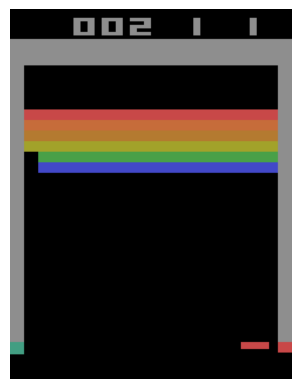

 40%|████      | 201/500 [02:37<03:46,  1.32it/s]

End of Episode 200: Total Reward: 2.0


 40%|████      | 202/500 [02:37<03:50,  1.29it/s]

End of Episode 201: Total Reward: 2.0


 41%|████      | 203/500 [02:38<03:30,  1.41it/s]

End of Episode 202: Total Reward: 0.0


 41%|████      | 204/500 [02:39<04:00,  1.23it/s]

End of Episode 203: Total Reward: 3.0


 41%|████      | 205/500 [02:40<03:45,  1.31it/s]

End of Episode 204: Total Reward: 1.0


 41%|████      | 206/500 [02:40<03:50,  1.28it/s]

End of Episode 205: Total Reward: 2.0


 41%|████▏     | 207/500 [02:42<04:34,  1.07it/s]

End of Episode 206: Total Reward: 6.0


 42%|████▏     | 208/500 [02:42<04:08,  1.17it/s]

End of Episode 207: Total Reward: 1.0


 42%|████▏     | 209/500 [02:43<03:50,  1.26it/s]

End of Episode 208: Total Reward: 1.0


 42%|████▏     | 210/500 [02:44<03:38,  1.33it/s]

End of Episode 209: Total Reward: 1.0


 42%|████▏     | 211/500 [02:45<04:14,  1.14it/s]

End of Episode 210: Total Reward: 4.0


 42%|████▏     | 212/500 [02:45<03:47,  1.27it/s]

End of Episode 211: Total Reward: 0.0


 43%|████▎     | 213/500 [02:46<03:58,  1.20it/s]

End of Episode 212: Total Reward: 2.0


 43%|████▎     | 214/500 [02:47<04:00,  1.19it/s]

End of Episode 213: Total Reward: 2.0


 43%|████▎     | 215/500 [02:48<03:58,  1.20it/s]

End of Episode 214: Total Reward: 2.0


 43%|████▎     | 216/500 [02:49<03:38,  1.30it/s]

End of Episode 215: Total Reward: 0.0


 43%|████▎     | 217/500 [02:50<04:14,  1.11it/s]

End of Episode 216: Total Reward: 4.0


 44%|████▎     | 218/500 [02:50<03:49,  1.23it/s]

End of Episode 217: Total Reward: 1.0


 44%|████▍     | 219/500 [02:51<03:35,  1.30it/s]

End of Episode 218: Total Reward: 1.0


 44%|████▍     | 220/500 [02:52<03:59,  1.17it/s]

End of Episode 219: Total Reward: 2.0


 44%|████▍     | 221/500 [02:53<04:06,  1.13it/s]

End of Episode 220: Total Reward: 3.0


 44%|████▍     | 222/500 [02:54<04:09,  1.11it/s]

End of Episode 221: Total Reward: 2.0


 45%|████▍     | 223/500 [02:55<03:54,  1.18it/s]

End of Episode 222: Total Reward: 1.0


 45%|████▍     | 224/500 [02:56<03:50,  1.19it/s]

End of Episode 223: Total Reward: 2.0


 45%|████▌     | 225/500 [02:56<03:44,  1.22it/s]

End of Episode 224: Total Reward: 1.0


 45%|████▌     | 226/500 [02:57<03:33,  1.28it/s]

End of Episode 225: Total Reward: 1.0


 45%|████▌     | 227/500 [02:58<03:39,  1.24it/s]

End of Episode 226: Total Reward: 2.0


 46%|████▌     | 228/500 [02:59<03:47,  1.20it/s]

End of Episode 227: Total Reward: 2.0


 46%|████▌     | 229/500 [02:59<03:20,  1.35it/s]

End of Episode 228: Total Reward: 0.0


 46%|████▌     | 230/500 [03:00<03:41,  1.22it/s]

End of Episode 229: Total Reward: 3.0


 46%|████▌     | 231/500 [03:01<03:28,  1.29it/s]

End of Episode 230: Total Reward: 1.0


 46%|████▋     | 232/500 [03:02<03:25,  1.30it/s]

End of Episode 231: Total Reward: 2.0


 47%|████▋     | 233/500 [03:03<03:24,  1.31it/s]

End of Episode 232: Total Reward: 2.0


 47%|████▋     | 234/500 [03:04<03:38,  1.22it/s]

End of Episode 233: Total Reward: 3.0


 47%|████▋     | 235/500 [03:04<03:10,  1.39it/s]

End of Episode 234: Total Reward: 0.0


 47%|████▋     | 236/500 [03:05<03:31,  1.25it/s]

End of Episode 235: Total Reward: 3.0


 47%|████▋     | 237/500 [03:06<03:38,  1.21it/s]

End of Episode 236: Total Reward: 3.0


 48%|████▊     | 238/500 [03:06<03:10,  1.38it/s]

End of Episode 237: Total Reward: 0.0


 48%|████▊     | 239/500 [03:07<02:51,  1.52it/s]

End of Episode 238: Total Reward: 0.0


 48%|████▊     | 240/500 [03:08<03:20,  1.29it/s]

End of Episode 239: Total Reward: 4.0


 48%|████▊     | 241/500 [03:09<03:34,  1.21it/s]

End of Episode 240: Total Reward: 3.0


 48%|████▊     | 242/500 [03:09<03:06,  1.38it/s]

End of Episode 241: Total Reward: 0.0


 49%|████▊     | 243/500 [03:10<02:48,  1.52it/s]

End of Episode 242: Total Reward: 0.0


 49%|████▉     | 244/500 [03:11<02:52,  1.49it/s]

End of Episode 243: Total Reward: 1.0


 49%|████▉     | 245/500 [03:11<03:10,  1.34it/s]

End of Episode 244: Total Reward: 3.0


 49%|████▉     | 246/500 [03:12<03:03,  1.38it/s]

End of Episode 245: Total Reward: 1.0


 49%|████▉     | 247/500 [03:13<02:54,  1.45it/s]

End of Episode 246: Total Reward: 1.0


 50%|████▉     | 248/500 [03:14<03:03,  1.37it/s]

End of Episode 247: Total Reward: 2.0


 50%|████▉     | 249/500 [03:14<02:53,  1.44it/s]

End of Episode 248: Total Reward: 1.0


 50%|█████     | 250/500 [03:15<02:38,  1.58it/s]

End of Episode 249: Total Reward: 0.0


 50%|█████     | 251/500 [03:15<02:47,  1.49it/s]

End of Episode 250: Total Reward: 2.0


 50%|█████     | 252/500 [03:16<02:49,  1.46it/s]

End of Episode 251: Total Reward: 2.0


 51%|█████     | 253/500 [03:17<03:07,  1.32it/s]

End of Episode 252: Total Reward: 3.0


 51%|█████     | 254/500 [03:18<03:31,  1.16it/s]

End of Episode 253: Total Reward: 5.0


 51%|█████     | 255/500 [03:19<03:29,  1.17it/s]

End of Episode 254: Total Reward: 2.0


 51%|█████     | 256/500 [03:20<03:06,  1.31it/s]

End of Episode 255: Total Reward: 0.0


 51%|█████▏    | 257/500 [03:20<02:47,  1.45it/s]

End of Episode 256: Total Reward: 0.0


 52%|█████▏    | 258/500 [03:21<02:31,  1.59it/s]

End of Episode 257: Total Reward: 0.0


 52%|█████▏    | 259/500 [03:22<02:58,  1.35it/s]

End of Episode 258: Total Reward: 4.0


 52%|█████▏    | 260/500 [03:22<02:51,  1.40it/s]

End of Episode 259: Total Reward: 1.0


 52%|█████▏    | 261/500 [03:23<02:46,  1.43it/s]

End of Episode 260: Total Reward: 1.0


 52%|█████▏    | 262/500 [03:24<02:41,  1.48it/s]

End of Episode 261: Total Reward: 1.0


 53%|█████▎    | 263/500 [03:24<02:28,  1.59it/s]

End of Episode 262: Total Reward: 0.0


 53%|█████▎    | 264/500 [03:25<02:34,  1.53it/s]

End of Episode 263: Total Reward: 1.0


 53%|█████▎    | 265/500 [03:25<02:35,  1.51it/s]

End of Episode 264: Total Reward: 1.0


 53%|█████▎    | 266/500 [03:26<02:42,  1.44it/s]

End of Episode 265: Total Reward: 2.0


 53%|█████▎    | 267/500 [03:27<03:09,  1.23it/s]

End of Episode 266: Total Reward: 4.0


 54%|█████▎    | 268/500 [03:28<02:55,  1.32it/s]

End of Episode 267: Total Reward: 1.0


 54%|█████▍    | 269/500 [03:29<03:08,  1.22it/s]

End of Episode 268: Total Reward: 3.0


 54%|█████▍    | 270/500 [03:30<03:10,  1.21it/s]

End of Episode 269: Total Reward: 3.0


 54%|█████▍    | 271/500 [03:30<02:46,  1.37it/s]

End of Episode 270: Total Reward: 0.0


 54%|█████▍    | 272/500 [03:31<02:43,  1.39it/s]

End of Episode 271: Total Reward: 2.0


 55%|█████▍    | 273/500 [03:32<02:45,  1.37it/s]

End of Episode 272: Total Reward: 2.0


 55%|█████▍    | 274/500 [03:32<02:39,  1.42it/s]

End of Episode 273: Total Reward: 1.0


 55%|█████▌    | 275/500 [03:33<02:22,  1.58it/s]

End of Episode 274: Total Reward: 0.0


 55%|█████▌    | 276/500 [03:33<02:14,  1.66it/s]

End of Episode 275: Total Reward: 0.0


 55%|█████▌    | 277/500 [03:34<02:18,  1.61it/s]

End of Episode 276: Total Reward: 1.0


 56%|█████▌    | 278/500 [03:35<02:24,  1.54it/s]

End of Episode 277: Total Reward: 1.0


 56%|█████▌    | 279/500 [03:35<02:18,  1.60it/s]

End of Episode 278: Total Reward: 1.0


 56%|█████▌    | 280/500 [03:36<02:20,  1.57it/s]

End of Episode 279: Total Reward: 1.0


 56%|█████▌    | 281/500 [03:37<02:31,  1.45it/s]

End of Episode 280: Total Reward: 2.0


 56%|█████▋    | 282/500 [03:38<02:34,  1.41it/s]

End of Episode 281: Total Reward: 2.0


 57%|█████▋    | 283/500 [03:38<02:39,  1.36it/s]

End of Episode 282: Total Reward: 2.0


 57%|█████▋    | 284/500 [03:39<02:50,  1.27it/s]

End of Episode 283: Total Reward: 3.0


 57%|█████▋    | 285/500 [03:40<02:55,  1.22it/s]

End of Episode 284: Total Reward: 3.0


 57%|█████▋    | 286/500 [03:41<02:33,  1.40it/s]

End of Episode 285: Total Reward: 0.0


 57%|█████▋    | 287/500 [03:41<02:17,  1.55it/s]

End of Episode 286: Total Reward: 0.0


 58%|█████▊    | 288/500 [03:42<02:06,  1.67it/s]

End of Episode 287: Total Reward: 0.0


 58%|█████▊    | 289/500 [03:42<02:20,  1.50it/s]

End of Episode 288: Total Reward: 3.0


 58%|█████▊    | 290/500 [03:43<02:16,  1.53it/s]

End of Episode 289: Total Reward: 1.0


 58%|█████▊    | 291/500 [03:43<02:04,  1.68it/s]

End of Episode 290: Total Reward: 0.0


 58%|█████▊    | 292/500 [03:44<02:05,  1.66it/s]

End of Episode 291: Total Reward: 1.0


 59%|█████▊    | 293/500 [03:45<02:08,  1.61it/s]

End of Episode 292: Total Reward: 1.0


 59%|█████▉    | 294/500 [03:45<02:13,  1.54it/s]

End of Episode 293: Total Reward: 1.0


 59%|█████▉    | 295/500 [03:46<02:08,  1.60it/s]

End of Episode 294: Total Reward: 1.0


 59%|█████▉    | 296/500 [03:46<01:58,  1.72it/s]

End of Episode 295: Total Reward: 0.0


 59%|█████▉    | 297/500 [03:47<02:00,  1.69it/s]

End of Episode 296: Total Reward: 1.0


 60%|█████▉    | 298/500 [03:48<02:11,  1.54it/s]

End of Episode 297: Total Reward: 2.0


 60%|█████▉    | 299/500 [03:49<02:08,  1.57it/s]

End of Episode 298: Total Reward: 1.0


 60%|██████    | 300/500 [03:49<02:18,  1.44it/s]

End of Episode 299: Total Reward: 1.0
Episode 300, Reward: 2.0


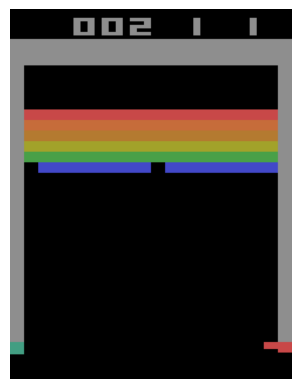

 60%|██████    | 301/500 [03:50<02:31,  1.31it/s]

End of Episode 300: Total Reward: 2.0


 60%|██████    | 302/500 [03:51<02:39,  1.24it/s]

End of Episode 301: Total Reward: 2.0


 61%|██████    | 303/500 [03:52<02:29,  1.32it/s]

End of Episode 302: Total Reward: 0.0


 61%|██████    | 304/500 [03:53<02:29,  1.31it/s]

End of Episode 303: Total Reward: 1.0


 61%|██████    | 305/500 [03:53<02:20,  1.38it/s]

End of Episode 304: Total Reward: 1.0


 61%|██████    | 306/500 [03:54<02:21,  1.37it/s]

End of Episode 305: Total Reward: 1.0


 61%|██████▏   | 307/500 [03:55<02:30,  1.28it/s]

End of Episode 306: Total Reward: 2.0


 62%|██████▏   | 308/500 [03:56<02:37,  1.22it/s]

End of Episode 307: Total Reward: 2.0


 62%|██████▏   | 309/500 [03:56<02:22,  1.34it/s]

End of Episode 308: Total Reward: 0.0


 62%|██████▏   | 310/500 [03:57<02:17,  1.38it/s]

End of Episode 309: Total Reward: 1.0


 62%|██████▏   | 311/500 [03:58<02:07,  1.48it/s]

End of Episode 310: Total Reward: 0.0


 62%|██████▏   | 312/500 [03:59<02:25,  1.29it/s]

End of Episode 311: Total Reward: 3.0


 63%|██████▎   | 313/500 [04:00<02:59,  1.04it/s]

End of Episode 312: Total Reward: 5.0


 63%|██████▎   | 314/500 [04:01<02:47,  1.11it/s]

End of Episode 313: Total Reward: 1.0


 63%|██████▎   | 315/500 [04:01<02:30,  1.23it/s]

End of Episode 314: Total Reward: 1.0


 63%|██████▎   | 316/500 [04:02<02:26,  1.25it/s]

End of Episode 315: Total Reward: 1.0


 63%|██████▎   | 317/500 [04:03<02:13,  1.38it/s]

End of Episode 316: Total Reward: 0.0


 64%|██████▎   | 318/500 [04:03<02:03,  1.47it/s]

End of Episode 317: Total Reward: 0.0


 64%|██████▍   | 319/500 [04:04<02:03,  1.46it/s]

End of Episode 318: Total Reward: 1.0


 64%|██████▍   | 320/500 [04:05<02:36,  1.15it/s]

End of Episode 319: Total Reward: 5.0


 64%|██████▍   | 321/500 [04:06<02:32,  1.17it/s]

End of Episode 320: Total Reward: 1.0


 64%|██████▍   | 322/500 [04:07<02:23,  1.24it/s]

End of Episode 321: Total Reward: 1.0


 65%|██████▍   | 323/500 [04:08<02:51,  1.04it/s]

End of Episode 322: Total Reward: 5.0


 65%|██████▍   | 324/500 [04:09<02:42,  1.09it/s]

End of Episode 323: Total Reward: 1.0


 65%|██████▌   | 325/500 [04:10<02:28,  1.18it/s]

End of Episode 324: Total Reward: 1.0


 65%|██████▌   | 326/500 [04:10<02:29,  1.17it/s]

End of Episode 325: Total Reward: 2.0


 65%|██████▌   | 327/500 [04:11<02:26,  1.18it/s]

End of Episode 326: Total Reward: 2.0


 66%|██████▌   | 328/500 [04:12<02:15,  1.27it/s]

End of Episode 327: Total Reward: 0.0


 66%|██████▌   | 329/500 [04:12<02:01,  1.41it/s]

End of Episode 328: Total Reward: 0.0


 66%|██████▌   | 330/500 [04:13<02:13,  1.28it/s]

End of Episode 329: Total Reward: 2.0


 66%|██████▌   | 331/500 [04:14<02:02,  1.38it/s]

End of Episode 330: Total Reward: 0.0


 66%|██████▋   | 332/500 [04:15<02:09,  1.29it/s]

End of Episode 331: Total Reward: 3.0


 67%|██████▋   | 333/500 [04:15<01:54,  1.45it/s]

End of Episode 332: Total Reward: 0.0


 67%|██████▋   | 334/500 [04:16<01:42,  1.62it/s]

End of Episode 333: Total Reward: 0.0


 67%|██████▋   | 335/500 [04:17<01:44,  1.57it/s]

End of Episode 334: Total Reward: 1.0


 67%|██████▋   | 336/500 [04:17<01:43,  1.58it/s]

End of Episode 335: Total Reward: 1.0


 67%|██████▋   | 337/500 [04:18<01:38,  1.66it/s]

End of Episode 336: Total Reward: 0.0


 68%|██████▊   | 338/500 [04:18<01:47,  1.50it/s]

End of Episode 337: Total Reward: 2.0


 68%|██████▊   | 339/500 [04:19<01:50,  1.46it/s]

End of Episode 338: Total Reward: 2.0


 68%|██████▊   | 340/500 [04:20<01:42,  1.56it/s]

End of Episode 339: Total Reward: 0.0


 68%|██████▊   | 341/500 [04:21<01:53,  1.41it/s]

End of Episode 340: Total Reward: 3.0


 68%|██████▊   | 342/500 [04:21<01:43,  1.52it/s]

End of Episode 341: Total Reward: 0.0


 69%|██████▊   | 343/500 [04:22<01:35,  1.64it/s]

End of Episode 342: Total Reward: 0.0


 69%|██████▉   | 344/500 [04:22<01:30,  1.73it/s]

End of Episode 343: Total Reward: 0.0


 69%|██████▉   | 345/500 [04:23<01:31,  1.69it/s]

End of Episode 344: Total Reward: 0.0


 69%|██████▉   | 346/500 [04:23<01:30,  1.71it/s]

End of Episode 345: Total Reward: 1.0


 69%|██████▉   | 347/500 [04:24<01:34,  1.62it/s]

End of Episode 346: Total Reward: 1.0


 70%|██████▉   | 348/500 [04:25<01:37,  1.56it/s]

End of Episode 347: Total Reward: 1.0


 70%|██████▉   | 349/500 [04:25<01:29,  1.69it/s]

End of Episode 348: Total Reward: 0.0


 70%|███████   | 350/500 [04:26<01:40,  1.50it/s]

End of Episode 349: Total Reward: 2.0


 70%|███████   | 351/500 [04:27<01:32,  1.62it/s]

End of Episode 350: Total Reward: 0.0


 70%|███████   | 352/500 [04:27<01:27,  1.70it/s]

End of Episode 351: Total Reward: 0.0


 71%|███████   | 353/500 [04:28<01:32,  1.59it/s]

End of Episode 352: Total Reward: 1.0


 71%|███████   | 354/500 [04:28<01:33,  1.56it/s]

End of Episode 353: Total Reward: 1.0


 71%|███████   | 355/500 [04:29<01:26,  1.68it/s]

End of Episode 354: Total Reward: 0.0


 71%|███████   | 356/500 [04:30<01:59,  1.20it/s]

End of Episode 355: Total Reward: 5.0


 71%|███████▏  | 357/500 [04:31<01:52,  1.27it/s]

End of Episode 356: Total Reward: 1.0


 72%|███████▏  | 358/500 [04:32<01:48,  1.31it/s]

End of Episode 357: Total Reward: 1.0


 72%|███████▏  | 359/500 [04:33<02:03,  1.14it/s]

End of Episode 358: Total Reward: 4.0


 72%|███████▏  | 360/500 [04:33<01:45,  1.33it/s]

End of Episode 359: Total Reward: 0.0


 72%|███████▏  | 361/500 [04:34<01:51,  1.24it/s]

End of Episode 360: Total Reward: 3.0


 72%|███████▏  | 362/500 [04:35<01:41,  1.37it/s]

End of Episode 361: Total Reward: 0.0


 73%|███████▎  | 363/500 [04:36<01:38,  1.39it/s]

End of Episode 362: Total Reward: 0.0


 73%|███████▎  | 364/500 [04:36<01:37,  1.39it/s]

End of Episode 363: Total Reward: 1.0


 73%|███████▎  | 365/500 [04:37<01:35,  1.41it/s]

End of Episode 364: Total Reward: 1.0


 73%|███████▎  | 366/500 [04:38<01:33,  1.43it/s]

End of Episode 365: Total Reward: 1.0


 73%|███████▎  | 367/500 [04:38<01:32,  1.44it/s]

End of Episode 366: Total Reward: 1.0


 74%|███████▎  | 368/500 [04:39<01:46,  1.24it/s]

End of Episode 367: Total Reward: 4.0


 74%|███████▍  | 369/500 [04:40<01:38,  1.34it/s]

End of Episode 368: Total Reward: 1.0


 74%|███████▍  | 370/500 [04:41<01:48,  1.19it/s]

End of Episode 369: Total Reward: 3.0


 74%|███████▍  | 371/500 [04:42<01:42,  1.26it/s]

End of Episode 370: Total Reward: 1.0


 74%|███████▍  | 372/500 [04:43<01:55,  1.11it/s]

End of Episode 371: Total Reward: 4.0


 75%|███████▍  | 373/500 [04:44<01:56,  1.09it/s]

End of Episode 372: Total Reward: 3.0


 75%|███████▍  | 374/500 [04:45<01:56,  1.08it/s]

End of Episode 373: Total Reward: 3.0


 75%|███████▌  | 375/500 [04:46<01:52,  1.11it/s]

End of Episode 374: Total Reward: 2.0


 75%|███████▌  | 376/500 [04:47<01:53,  1.09it/s]

End of Episode 375: Total Reward: 2.0


 75%|███████▌  | 377/500 [04:47<01:47,  1.14it/s]

End of Episode 376: Total Reward: 2.0


 76%|███████▌  | 378/500 [04:48<01:44,  1.17it/s]

End of Episode 377: Total Reward: 2.0


 76%|███████▌  | 379/500 [04:49<01:41,  1.19it/s]

End of Episode 378: Total Reward: 2.0


 76%|███████▌  | 380/500 [04:49<01:27,  1.37it/s]

End of Episode 379: Total Reward: 0.0


 76%|███████▌  | 381/500 [04:50<01:39,  1.19it/s]

End of Episode 380: Total Reward: 4.0


 76%|███████▋  | 382/500 [04:51<01:37,  1.21it/s]

End of Episode 381: Total Reward: 2.0


 77%|███████▋  | 383/500 [04:52<01:31,  1.28it/s]

End of Episode 382: Total Reward: 1.0


 77%|███████▋  | 384/500 [04:53<01:24,  1.37it/s]

End of Episode 383: Total Reward: 1.0


 77%|███████▋  | 385/500 [04:53<01:27,  1.31it/s]

End of Episode 384: Total Reward: 3.0


 77%|███████▋  | 386/500 [04:54<01:33,  1.22it/s]

End of Episode 385: Total Reward: 3.0


 77%|███████▋  | 387/500 [04:55<01:22,  1.36it/s]

End of Episode 386: Total Reward: 0.0


 78%|███████▊  | 388/500 [04:56<01:18,  1.43it/s]

End of Episode 387: Total Reward: 1.0


 78%|███████▊  | 389/500 [04:56<01:22,  1.35it/s]

End of Episode 388: Total Reward: 2.0


 78%|███████▊  | 390/500 [04:57<01:19,  1.38it/s]

End of Episode 389: Total Reward: 1.0


 78%|███████▊  | 391/500 [04:58<01:16,  1.43it/s]

End of Episode 390: Total Reward: 0.0


 78%|███████▊  | 392/500 [04:59<01:20,  1.35it/s]

End of Episode 391: Total Reward: 2.0


 79%|███████▊  | 393/500 [04:59<01:18,  1.36it/s]

End of Episode 392: Total Reward: 1.0


 79%|███████▉  | 394/500 [05:00<01:15,  1.40it/s]

End of Episode 393: Total Reward: 1.0


 79%|███████▉  | 395/500 [05:00<01:08,  1.53it/s]

End of Episode 394: Total Reward: 0.0


 79%|███████▉  | 396/500 [05:01<01:13,  1.42it/s]

End of Episode 395: Total Reward: 2.0


 79%|███████▉  | 397/500 [05:02<01:05,  1.57it/s]

End of Episode 396: Total Reward: 0.0


 80%|███████▉  | 398/500 [05:02<01:04,  1.57it/s]

End of Episode 397: Total Reward: 1.0


 80%|███████▉  | 399/500 [05:03<01:08,  1.46it/s]

End of Episode 398: Total Reward: 2.0


 80%|████████  | 400/500 [05:04<01:05,  1.53it/s]

End of Episode 399: Total Reward: 1.0
Episode 400, Reward: 3.0


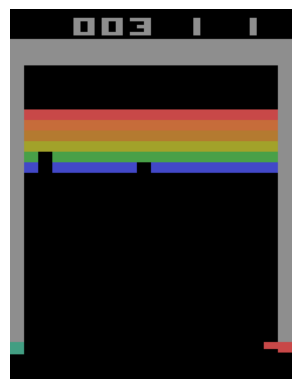

 80%|████████  | 401/500 [05:05<01:12,  1.37it/s]

End of Episode 400: Total Reward: 3.0


 80%|████████  | 402/500 [05:05<01:04,  1.51it/s]

End of Episode 401: Total Reward: 0.0


 81%|████████  | 403/500 [05:06<01:00,  1.60it/s]

End of Episode 402: Total Reward: 0.0


 81%|████████  | 404/500 [05:07<01:08,  1.41it/s]

End of Episode 403: Total Reward: 2.0


 81%|████████  | 405/500 [05:07<01:03,  1.50it/s]

End of Episode 404: Total Reward: 0.0


 81%|████████  | 406/500 [05:08<00:58,  1.59it/s]

End of Episode 405: Total Reward: 0.0


 81%|████████▏ | 407/500 [05:08<00:57,  1.61it/s]

End of Episode 406: Total Reward: 0.0


 82%|████████▏ | 408/500 [05:09<01:01,  1.50it/s]

End of Episode 407: Total Reward: 2.0


 82%|████████▏ | 409/500 [05:10<00:59,  1.54it/s]

End of Episode 408: Total Reward: 1.0


 82%|████████▏ | 410/500 [05:10<00:55,  1.61it/s]

End of Episode 409: Total Reward: 0.0


 82%|████████▏ | 411/500 [05:11<00:54,  1.64it/s]

End of Episode 410: Total Reward: 0.0


 82%|████████▏ | 412/500 [05:12<00:56,  1.56it/s]

End of Episode 411: Total Reward: 2.0


 83%|████████▎ | 413/500 [05:12<01:00,  1.43it/s]

End of Episode 412: Total Reward: 2.0


 83%|████████▎ | 414/500 [05:13<00:58,  1.46it/s]

End of Episode 413: Total Reward: 1.0


 83%|████████▎ | 415/500 [05:14<00:58,  1.45it/s]

End of Episode 414: Total Reward: 1.0


 83%|████████▎ | 416/500 [05:15<01:10,  1.19it/s]

End of Episode 415: Total Reward: 4.0


 83%|████████▎ | 417/500 [05:16<01:09,  1.19it/s]

End of Episode 416: Total Reward: 2.0


 84%|████████▎ | 418/500 [05:17<01:09,  1.18it/s]

End of Episode 417: Total Reward: 2.0


 84%|████████▍ | 419/500 [05:17<01:05,  1.24it/s]

End of Episode 418: Total Reward: 1.0


 84%|████████▍ | 420/500 [05:18<01:02,  1.27it/s]

End of Episode 419: Total Reward: 2.0


 84%|████████▍ | 421/500 [05:19<00:59,  1.32it/s]

End of Episode 420: Total Reward: 1.0


 84%|████████▍ | 422/500 [05:19<00:55,  1.40it/s]

End of Episode 421: Total Reward: 1.0


 85%|████████▍ | 423/500 [05:20<00:52,  1.46it/s]

End of Episode 422: Total Reward: 1.0


 85%|████████▍ | 424/500 [05:21<00:54,  1.40it/s]

End of Episode 423: Total Reward: 2.0


 85%|████████▌ | 425/500 [05:21<00:51,  1.45it/s]

End of Episode 424: Total Reward: 1.0


 85%|████████▌ | 426/500 [05:23<01:01,  1.21it/s]

End of Episode 425: Total Reward: 4.0


 85%|████████▌ | 427/500 [05:23<01:00,  1.20it/s]

End of Episode 426: Total Reward: 3.0


 86%|████████▌ | 428/500 [05:24<00:58,  1.24it/s]

End of Episode 427: Total Reward: 2.0


 86%|████████▌ | 429/500 [05:25<00:52,  1.34it/s]

End of Episode 428: Total Reward: 0.0


 86%|████████▌ | 430/500 [05:26<00:55,  1.26it/s]

End of Episode 429: Total Reward: 3.0


 86%|████████▌ | 431/500 [05:26<00:49,  1.38it/s]

End of Episode 430: Total Reward: 0.0


 86%|████████▋ | 432/500 [05:27<00:50,  1.34it/s]

End of Episode 431: Total Reward: 2.0


 87%|████████▋ | 433/500 [05:28<00:57,  1.17it/s]

End of Episode 432: Total Reward: 4.0


 87%|████████▋ | 434/500 [05:29<00:58,  1.13it/s]

End of Episode 433: Total Reward: 3.0


 87%|████████▋ | 435/500 [05:30<00:58,  1.11it/s]

End of Episode 434: Total Reward: 3.0


 87%|████████▋ | 436/500 [05:31<00:56,  1.13it/s]

End of Episode 435: Total Reward: 2.0


 87%|████████▋ | 437/500 [05:31<00:48,  1.31it/s]

End of Episode 436: Total Reward: 0.0


 88%|████████▊ | 438/500 [05:32<00:44,  1.41it/s]

End of Episode 437: Total Reward: 0.0


 88%|████████▊ | 439/500 [05:32<00:39,  1.53it/s]

End of Episode 438: Total Reward: 0.0


 88%|████████▊ | 440/500 [05:33<00:37,  1.59it/s]

End of Episode 439: Total Reward: 0.0


 88%|████████▊ | 441/500 [05:34<00:37,  1.56it/s]

End of Episode 440: Total Reward: 1.0


 88%|████████▊ | 442/500 [05:35<00:46,  1.25it/s]

End of Episode 441: Total Reward: 5.0


 89%|████████▊ | 443/500 [05:36<00:45,  1.25it/s]

End of Episode 442: Total Reward: 3.0


 89%|████████▉ | 444/500 [05:36<00:39,  1.41it/s]

End of Episode 443: Total Reward: 0.0


 89%|████████▉ | 445/500 [05:37<00:37,  1.46it/s]

End of Episode 444: Total Reward: 1.0


 89%|████████▉ | 446/500 [05:38<00:41,  1.31it/s]

End of Episode 445: Total Reward: 3.0


 89%|████████▉ | 447/500 [05:38<00:38,  1.36it/s]

End of Episode 446: Total Reward: 1.0


 90%|████████▉ | 448/500 [05:39<00:34,  1.50it/s]

End of Episode 447: Total Reward: 0.0


 90%|████████▉ | 449/500 [05:39<00:31,  1.60it/s]

End of Episode 448: Total Reward: 0.0


 90%|█████████ | 450/500 [05:40<00:36,  1.36it/s]

End of Episode 449: Total Reward: 4.0


 90%|█████████ | 451/500 [05:41<00:35,  1.37it/s]

End of Episode 450: Total Reward: 1.0


 90%|█████████ | 452/500 [05:42<00:32,  1.47it/s]

End of Episode 451: Total Reward: 0.0


 91%|█████████ | 453/500 [05:43<00:37,  1.27it/s]

End of Episode 452: Total Reward: 4.0


 91%|█████████ | 454/500 [05:43<00:33,  1.37it/s]

End of Episode 453: Total Reward: 1.0


 91%|█████████ | 455/500 [05:44<00:34,  1.29it/s]

End of Episode 454: Total Reward: 3.0


 91%|█████████ | 456/500 [05:45<00:30,  1.46it/s]

End of Episode 455: Total Reward: 0.0


 91%|█████████▏| 457/500 [05:45<00:29,  1.47it/s]

End of Episode 456: Total Reward: 1.0


 92%|█████████▏| 458/500 [05:46<00:30,  1.39it/s]

End of Episode 457: Total Reward: 2.0


 92%|█████████▏| 459/500 [05:47<00:34,  1.20it/s]

End of Episode 458: Total Reward: 3.0


 92%|█████████▏| 460/500 [05:48<00:29,  1.36it/s]

End of Episode 459: Total Reward: 0.0


 92%|█████████▏| 461/500 [05:48<00:28,  1.38it/s]

End of Episode 460: Total Reward: 1.0


 92%|█████████▏| 462/500 [05:49<00:30,  1.23it/s]

End of Episode 461: Total Reward: 5.0


 93%|█████████▎| 463/500 [05:50<00:31,  1.18it/s]

End of Episode 462: Total Reward: 3.0


 93%|█████████▎| 464/500 [05:51<00:31,  1.13it/s]

End of Episode 463: Total Reward: 4.0


 93%|█████████▎| 465/500 [05:52<00:28,  1.22it/s]

End of Episode 464: Total Reward: 1.0


 93%|█████████▎| 466/500 [05:53<00:24,  1.40it/s]

End of Episode 465: Total Reward: 0.0


 93%|█████████▎| 467/500 [05:53<00:22,  1.47it/s]

End of Episode 466: Total Reward: 0.0


 94%|█████████▎| 468/500 [05:54<00:20,  1.54it/s]

End of Episode 467: Total Reward: 0.0


 94%|█████████▍| 469/500 [05:54<00:18,  1.65it/s]

End of Episode 468: Total Reward: 0.0


 94%|█████████▍| 470/500 [05:55<00:21,  1.37it/s]

End of Episode 469: Total Reward: 3.0


 94%|█████████▍| 471/500 [05:56<00:20,  1.44it/s]

End of Episode 470: Total Reward: 1.0


 94%|█████████▍| 472/500 [05:56<00:18,  1.51it/s]

End of Episode 471: Total Reward: 0.0


 95%|█████████▍| 473/500 [05:57<00:18,  1.44it/s]

End of Episode 472: Total Reward: 2.0


 95%|█████████▍| 474/500 [05:58<00:17,  1.47it/s]

End of Episode 473: Total Reward: 1.0


 95%|█████████▌| 475/500 [05:59<00:19,  1.27it/s]

End of Episode 474: Total Reward: 4.0


 95%|█████████▌| 476/500 [06:00<00:17,  1.34it/s]

End of Episode 475: Total Reward: 0.0


 95%|█████████▌| 477/500 [06:00<00:18,  1.24it/s]

End of Episode 476: Total Reward: 3.0


 96%|█████████▌| 478/500 [06:01<00:17,  1.29it/s]

End of Episode 477: Total Reward: 1.0


 96%|█████████▌| 479/500 [06:02<00:18,  1.11it/s]

End of Episode 478: Total Reward: 4.0


 96%|█████████▌| 480/500 [06:03<00:18,  1.10it/s]

End of Episode 479: Total Reward: 3.0


 96%|█████████▌| 481/500 [06:04<00:16,  1.18it/s]

End of Episode 480: Total Reward: 1.0


 96%|█████████▋| 482/500 [06:05<00:13,  1.32it/s]

End of Episode 481: Total Reward: 0.0


 97%|█████████▋| 483/500 [06:05<00:12,  1.32it/s]

End of Episode 482: Total Reward: 2.0


 97%|█████████▋| 484/500 [06:06<00:11,  1.35it/s]

End of Episode 483: Total Reward: 1.0


 97%|█████████▋| 485/500 [06:07<00:10,  1.39it/s]

End of Episode 484: Total Reward: 1.0


 97%|█████████▋| 486/500 [06:07<00:08,  1.56it/s]

End of Episode 485: Total Reward: 0.0


 97%|█████████▋| 487/500 [06:08<00:08,  1.57it/s]

End of Episode 486: Total Reward: 1.0


 98%|█████████▊| 488/500 [06:09<00:07,  1.50it/s]

End of Episode 487: Total Reward: 2.0


 98%|█████████▊| 489/500 [06:09<00:06,  1.63it/s]

End of Episode 488: Total Reward: 0.0


 98%|█████████▊| 490/500 [06:10<00:06,  1.57it/s]

End of Episode 489: Total Reward: 1.0


 98%|█████████▊| 491/500 [06:10<00:05,  1.68it/s]

End of Episode 490: Total Reward: 0.0


 98%|█████████▊| 492/500 [06:11<00:05,  1.60it/s]

End of Episode 491: Total Reward: 1.0


 99%|█████████▊| 493/500 [06:12<00:04,  1.55it/s]

End of Episode 492: Total Reward: 1.0


 99%|█████████▉| 494/500 [06:12<00:04,  1.42it/s]

End of Episode 493: Total Reward: 2.0


 99%|█████████▉| 495/500 [06:13<00:03,  1.27it/s]

End of Episode 494: Total Reward: 3.0


 99%|█████████▉| 496/500 [06:14<00:02,  1.34it/s]

End of Episode 495: Total Reward: 1.0


 99%|█████████▉| 497/500 [06:15<00:02,  1.18it/s]

End of Episode 496: Total Reward: 4.0


100%|█████████▉| 498/500 [06:16<00:01,  1.20it/s]

End of Episode 497: Total Reward: 3.0


100%|█████████▉| 499/500 [06:17<00:00,  1.28it/s]

End of Episode 498: Total Reward: 1.0


100%|██████████| 500/500 [06:17<00:00,  1.32it/s]

End of Episode 499: Total Reward: 0.0
Model saved as breakout_ppo_model.pth


In [6]:
if __name__ == "__main__":
    env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')  # Инициализация игры
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    episodes = 500
    batch_size = 64
    gamma = 0.99
    epsilon = 0.2  
    lr = 0.00025

    train(
        env, 
        device, 
        episodes, 
        batch_size, 
        gamma, 
        epsilon, 
        lr
    )

In [10]:
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Создаем окружение для игры Breakout
    env = gym.make('ALE/Breakout-v5', render_mode="human")
    
    # Указываем параметры сети
    state_shape = (4, 84, 84)  # размер стека состояний (4 кадра)
    num_actions = env.action_space.n  # количество возможных действий

    # Создаем агента PPO
    agent = PPOAgent(
        env, 
        gamma=0.99, 
        lr=0.00025, 
        epsilon=0.2,  
        batch_size=64
    )

    agent.network.load_state_dict(torch.load("breakout_ppo_model.pth", map_location=device))
    agent.network.eval() 
    agent.epsilon = 0.05  

    for episode in range(10):
        state, _ = env.reset()

        state_gray = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        state_resized = cv2.resize(state_gray, (84, 84))
        
        # Стек состояний (4 кадра)
        state_stack = np.stack([state_resized] * 4, axis=0)
        
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state_stack)

            next_state, reward, done, truncated, _ = env.step(action)
            
            # Преобразование следующего состояния
            next_state_gray = cv2.cvtColor(next_state, cv2.COLOR_RGB2GRAY)
            next_state_resized = cv2.resize(next_state_gray, (84, 84))
            
            # Обновляем стек состояний
            next_state_stack = np.append(state_stack[1:], np.expand_dims(next_state_resized, axis=0), axis=0)
            
            state_stack = next_state_stack  
            total_reward += reward

        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    env.close()

if __name__ == "__main__":
    test()

C:\Users\user\AppData\Local\Temp\ipykernel_3308\3519803801.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.network.load_state_dict(torch.load("breakout_ppo_model.

Episode 1: Total Reward: 1.0
Episode 2: Total Reward: 0.0
Episode 3: Total Reward: 0.0
Episode 4: Total Reward: 2.0
Episode 5: Total Reward: 4.0
Episode 6: Total Reward: 0.0
Episode 7: Total Reward: 0.0
Episode 8: Total Reward: 0.0
Episode 9: Total Reward: 0.0
Episode 10: Total Reward: 2.0
